<hr>
<h1 align="center"> IEOR 242 - Final Project </h1>
<h2 align="center"> Tennis Prediction - Machine Learning with R</h2>
<h4 align="right"> By: Josh Edwards, Agustin Toll, Johan Gerfaux & David Scanlan </h4>
<hr>

## 1) The first step is import the packages that we are going to use:
**COMMENT:** We should comment what each library does. But let's do that later. Also, I think tidyverse includes some of the other libraries. </p>

In [1]:
library(tidyverse)
library(rpart)
library(rpart.plot)
library(caret)
library(caTools)
library(randomForest)
library(gbm)
library(plyr)
library(dplyr)
library(ggplot2)
library(GGally)
library(MASS)
library(ROCit)
library(PRROC)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.1          ✔ dplyr   0.8.5     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.1.5

------------------------------------------------------------------------------

You have loaded plyr after dp

## 2) Import the dataset:

We import the dataset and name it 'usopenData' using the read.csv() function:

In [2]:
usopenData <- read.csv('../input/usopendata/USOpen_matches_with_feature - USOpen_matches_with_feature.csv')

Let's take a look at the data:

In [3]:
summary(usopenData)
nrow(usopenData)
ncol(usopenData)

   Tournament           Date      Surface               Round    
 US Open:1181   2017/08/30:  38   Hard:1181   1st Round    :591  
                2019/08/27:  30               2nd Round    :301  
                2016/08/30:  29               3rd Round    :147  
                2017/08/28:  29               4th Round    : 76  
                2016/08/29:  28               Quarterfinals: 38  
                2015/09/01:  27               Semifinals   : 19  
                (Other)   :1000               The Final    :  9  
        player_0   player_0_rank     player_0_odd                player_1   
 Djokovic N.: 49   Min.   :  0.00   Min.   : 1.000   Kukushkin M.    :  15  
 Federer R. : 45   1st Qu.:  8.00   1st Qu.: 1.100   Young D.        :  14  
 Nadal R.   : 41   Median : 22.00   Median : 1.280   Kohlschreiber P.:  13  
 Murray A.  : 33   Mean   : 31.27   Mean   : 1.495   Anderson K.     :  12  
 Isner J.   : 29   3rd Qu.: 43.00   3rd Qu.: 1.570   Harrison R.     :  12  
 Cilic M. 

[1] 1181

[1] 72

As we can see, we have 1181 records and 72 features.

## 3) Data Manipulation:

Now, we transform the 'outcome' variable (that we are trying to predict) from a 0-1 variable to a factor variable. Otherwise CART may try it as regression. 

In [4]:
usopenData$outcome <- as.factor(usopenData$outcome)

In [5]:
usopenData2 <- usopenData[, -c(0:10)]
usopenData <- usopenData2[, -c(2:41)]
summary(usopenData)

 outcome   diff_rank        diff_match_win_percent diff_games_win_percent
 0:851   Min.   :-1383.00   Min.   :-0.60119       Min.   :-0.516427     
 1:330   1st Qu.:  -87.00   1st Qu.: 0.03333       1st Qu.: 0.005943     
         Median :  -48.00   Median : 0.14107       Median : 0.033047     
         Mean   :  -75.82   Mean   : 0.14977       Mean   : 0.041503     
         3rd Qu.:  -22.00   3rd Qu.: 0.25147       3rd Qu.: 0.062200     
         Max.   :   -1.00   Max.   : 0.85629       Max.   : 0.555465     
 diff_5_set_match_win_percent diff_close_sets_percent
 Min.   :-0.70492             Min.   :-0.522284      
 1st Qu.: 0.03595             1st Qu.: 0.008161      
 Median : 0.17484             Median : 0.065674      
 Mean   : 0.18531             Mean   : 0.073055      
 3rd Qu.: 0.33553             3rd Qu.: 0.125389      
 Max.   : 0.87647             Max.   : 0.610500      
 diff_match_win_percent_hard diff_games_win_percent_hard
 Min.   :-0.6395             Min.   :-0.539941 

## 4) Split training data and test data:

The function 'sample.split' splits the dataset smartly for binary outcomes: <br>
It keeps the same ratio of 1s and 0s in the training and test sets. <br>

SplitRatio = 0.7 means that we will put 70% of the data in the training set, 30% in the test set.

In [6]:
set.seed(737)
split <- sample.split(usopenData$outcome, SplitRatio = 0.7)
training <- filter(usopenData, split == TRUE)
test <- filter(usopenData, split == FALSE)

Let's see the results:

In [7]:
table(training$outcome)
table(test$outcome)


  0   1 
596 231 


  0   1 
255  99 

## 5) Create a Baseline:

Based on the results, we see that there are more 0s than 1s. Therefore, our baseline is a model that considers all of them 0s:

In [8]:
#FOR THE TEST DATASET:
accuracyBaseline <- 255/(255+99)
accuracyBaseline

[1] 0.720339

So, we have a dummy model with 72.03% of accuracy. We will try to build a CART model to improve that accuracy.

## 6) Machine Learning Models:

### ML1) Logistic Regression Model:

In [9]:
modelGLM1 <- glm(outcome ~ ., data = training, family="binomial")
summary(modelGLM1)


Call:
glm(formula = outcome ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8216  -0.8226  -0.5963   1.0770   2.8633  

Coefficients: (2 not defined because of singularities)
                                       Estimate Std. Error z value Pr(>|z|)   
(Intercept)                          -0.2258548  0.1240024  -1.821  0.06855 . 
diff_rank                             0.0005416  0.0011190   0.484  0.62839   
diff_match_win_percent                1.8290679  1.6684682   1.096  0.27297   
diff_games_win_percent               -5.3287180  4.6723980  -1.140  0.25409   
diff_5_set_match_win_percent         -1.3483213  0.8446164  -1.596  0.11041   
diff_close_sets_percent              -1.9335805  2.8039162  -0.690  0.49045   
diff_match_win_percent_hard          -4.3085658  1.4800026  -2.911  0.00360 **
diff_games_win_percent_hard          -1.7939362  3.0045923  -0.597  0.55046   
diff_5_set_match_win_percent_hard     0.6895046

**Keep variables that show signf. from Log Regress of all variables <br>
diff_match_win_percent_hard <br>
diff_close_sets_percent_hard <br>
diff_match_win_percent_52**

In [10]:
modelGLM2 <- glm(outcome ~diff_match_win_percent_hard+diff_close_sets_percent_hard +diff_match_win_percent_52 , data = training, family="binomial")
summary(modelGLM2)


Call:
glm(formula = outcome ~ diff_match_win_percent_hard + diff_close_sets_percent_hard + 
    diff_match_win_percent_52, family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6911  -0.8293  -0.6342   1.1368   2.6379  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -0.3043     0.1078  -2.823 0.004756 ** 
diff_match_win_percent_hard   -2.6871     0.7463  -3.601 0.000317 ***
diff_close_sets_percent_hard   1.6870     1.0203   1.653 0.098230 .  
diff_match_win_percent_52     -2.5982     0.5819  -4.465 8.01e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 979.69  on 826  degrees of freedom
Residual deviance: 903.21  on 823  degrees of freedom
AIC: 911.21

Number of Fisher Scoring iterations: 4


In [11]:
predlog<-predict(modelGLM2, type = 'response', newdata= training)


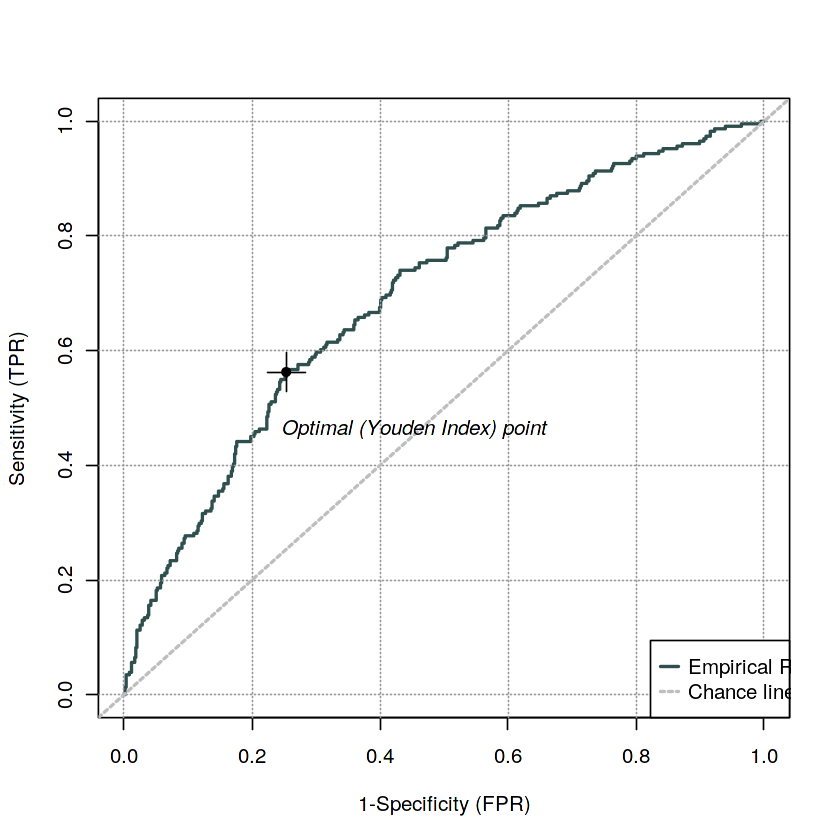

In [12]:
ROCobj<-rocit(score=predlog,class=training$outcome)
plot(ROCobj)

In [13]:
ROCobj$TPR[which.max(ROCobj$TPR-ROCobj$FPR)]
ROCobj$FPR[which.max(ROCobj$TPR-ROCobj$FPR)]
threshold <- ROCobj$Cutoff[which.max(ROCobj$TPR-ROCobj$FPR)]


[1] 0.5627706

[1] 0.2533557

In [14]:
pred.logistic <- predict(modelGLM2, type='response', newdata = test) 

logtable = table(test$outcome,pred.logistic> threshold)
logtable

   
    FALSE TRUE
  0   179   76
  1    34   65

In [15]:
tableAccuracy <- function(test, pred) {
  t = table(test, pred)
  a = sum(diag(t))/length(test)
  return(a)
}


tableAccuracy(test$outcome, pred.logistic> threshold)
##FPR
FPR = logtable[1,2]/(logtable[1,1]+logtable[2,2])
FPR
TPR = logtable[2,2]/(logtable[2,1]+logtable[2,2])
TPR

[1] 0.6892655

[1] 0.3114754

[1] 0.6565657

> AccuracyvGLM = 66.3
FPR= 32.3%
TPR = 56.5%

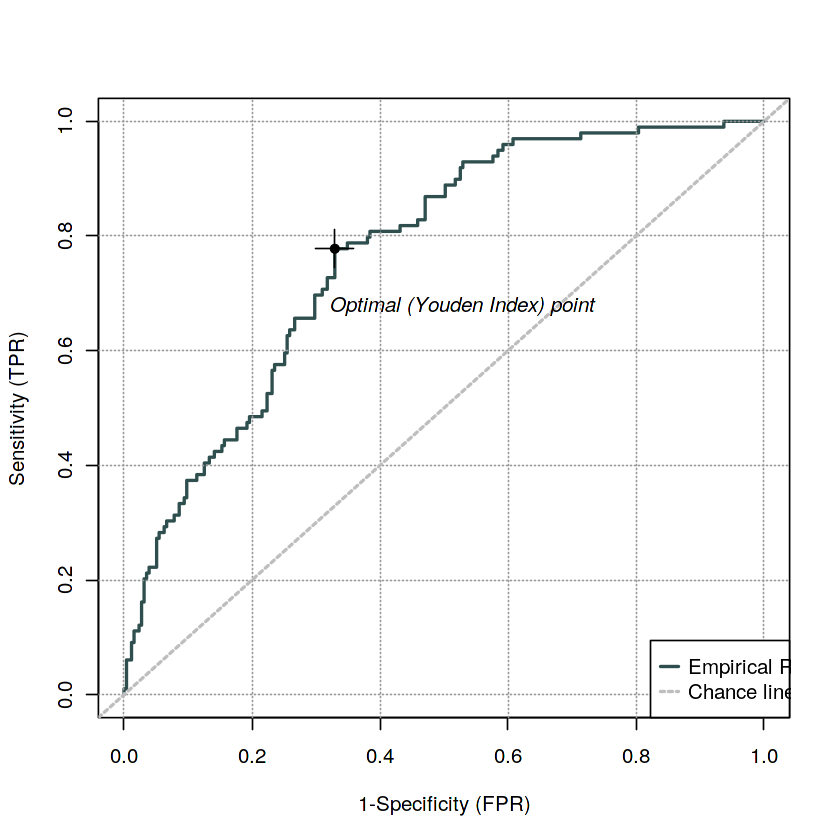

In [16]:
ROCobj <- rocit(score=pred.logistic,class=test$outcome)
plot(ROCobj)

In [17]:
ROCobj$AUC

[1] 0.7688651

In [18]:
accuracyGLM <- tableAccuracy(test$outcome, pred.logistic> threshold)
print(accuracyGLM)

[1] 0.6892655


### ML2) CART model

For this model:
1. We are going to do Cross Validation (10 fold).
2. We are not going to consider any Loss Matrix. 

In [19]:
modelCARTcv <- train(outcome ~.,
                    data = training,
                    method = "rpart",
                    tuneGrid = data.frame(cp=seq(0, 0.05, 0.002)),
                    trControl = trainControl(method="cv", number=10))
modelCARTcv

CART 

827 samples
 21 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 744, 744, 745, 745, 745, 745, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa      
  0.000  0.6722650  0.178155145
  0.002  0.6722650  0.176300343
  0.004  0.6867228  0.187516810
  0.006  0.6927473  0.196756519
  0.008  0.7024005  0.206544491
  0.010  0.6986703  0.175745609
  0.012  0.7011093  0.174679045
  0.014  0.7046951  0.172840242
  0.016  0.7047098  0.157241968
  0.018  0.7047098  0.157241968
  0.020  0.7071338  0.133558049
  0.022  0.7071631  0.133345318
  0.024  0.7071631  0.133345318
  0.026  0.7169192  0.104515021
  0.028  0.7169192  0.104515021
  0.030  0.7169192  0.104515021
  0.032  0.7169192  0.104515021
  0.034  0.7157585  0.074049386
  0.036  0.7157585  0.074049386
  0.038  0.7145537  0.068177145
  0.040  0.7158159  0.030067778
  0.042  0.7218694  0.020300580
  0.044  0.7194597  0.001303912
  0.046  0.7

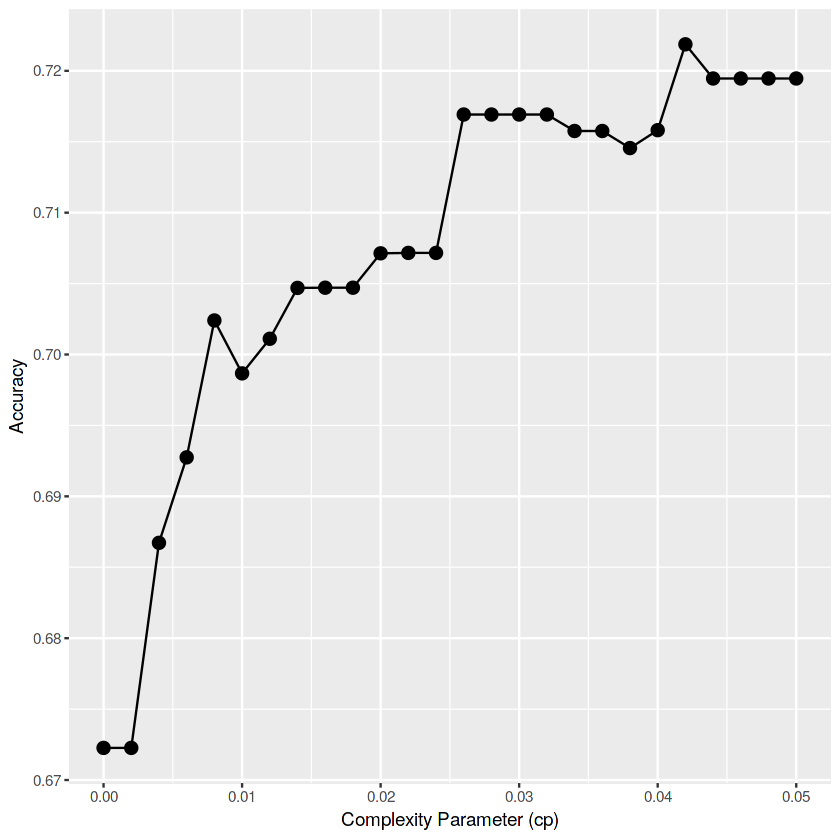

In [20]:
ggplot(modelCARTcv$results, aes(x=cp, y=Accuracy)) + geom_point(size=3) +
  xlab("Complexity Parameter (cp)") + geom_line()

In [21]:
modelCARTcv$bestTune

,cp
,<dbl>
22,0.042


In [22]:
modelCART <- modelCARTcv$finalModel

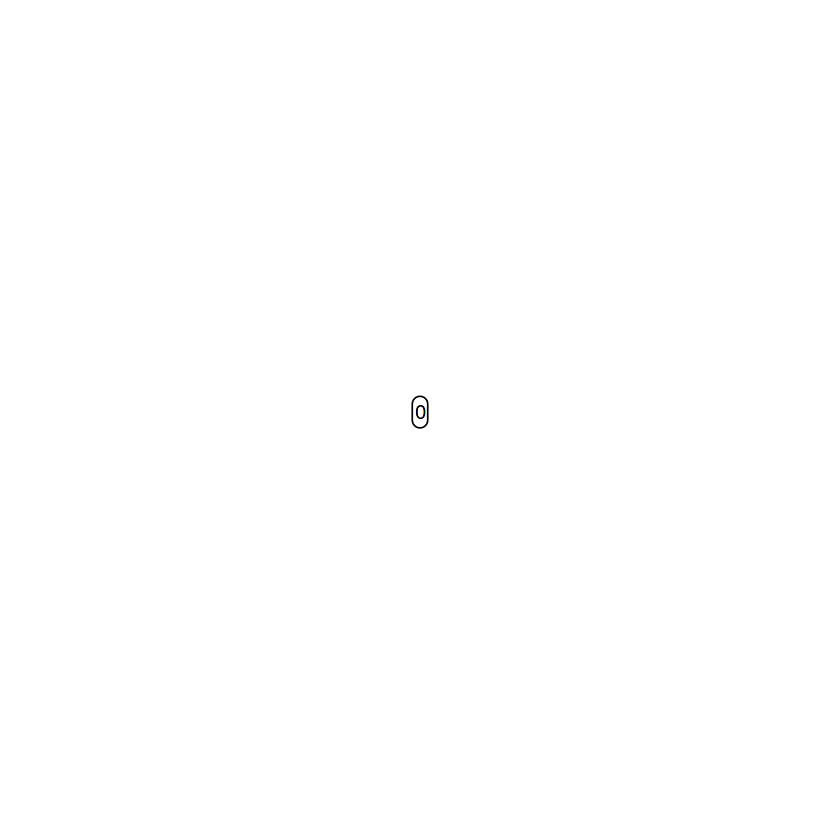

In [23]:
prp(modelCART, digits=3)

#### Performance:

In [24]:
predCART <- predict(modelCART, newdata = test, type = "class")  
accuracyCART <- sum(diag(table(test$outcome, predCART)))/sum(table(test$outcome, predCART))
accuracyCART

[1] 0.720339

### ML3) Random Forest Model:

In [25]:
modelRFcv <- train(outcome ~ .,
            data = training, method="rf",
            tuneGrid = data.frame(mtry=1:21),
            trControl = trainControl(method="cv", number=5, verboseIter=TRUE),
            metric="Accuracy")

+ Fold1: mtry= 1 
- Fold1: mtry= 1 
+ Fold1: mtry= 2 
- Fold1: mtry= 2 
+ Fold1: mtry= 3 
- Fold1: mtry= 3 
+ Fold1: mtry= 4 
- Fold1: mtry= 4 
+ Fold1: mtry= 5 
- Fold1: mtry= 5 
+ Fold1: mtry= 6 
- Fold1: mtry= 6 
+ Fold1: mtry= 7 
- Fold1: mtry= 7 
+ Fold1: mtry= 8 
- Fold1: mtry= 8 
+ Fold1: mtry= 9 
- Fold1: mtry= 9 
+ Fold1: mtry=10 
- Fold1: mtry=10 
+ Fold1: mtry=11 
- Fold1: mtry=11 
+ Fold1: mtry=12 
- Fold1: mtry=12 
+ Fold1: mtry=13 
- Fold1: mtry=13 
+ Fold1: mtry=14 
- Fold1: mtry=14 
+ Fold1: mtry=15 
- Fold1: mtry=15 
+ Fold1: mtry=16 
- Fold1: mtry=16 
+ Fold1: mtry=17 
- Fold1: mtry=17 
+ Fold1: mtry=18 
- Fold1: mtry=18 
+ Fold1: mtry=19 
- Fold1: mtry=19 
+ Fold1: mtry=20 
- Fold1: mtry=20 
+ Fold1: mtry=21 
- Fold1: mtry=21 
+ Fold2: mtry= 1 
- Fold2: mtry= 1 
+ Fold2: mtry= 2 
- Fold2: mtry= 2 
+ Fold2: mtry= 3 
- Fold2: mtry= 3 
+ Fold2: mtry= 4 
- Fold2: mtry= 4 
+ Fold2: mtry= 5 
- Fold2: mtry= 5 
+ Fold2: mtry= 6 
- Fold2: mtry= 6 
+ Fold2: mtry= 7 
- Fold2: m

In [26]:
modelRFcv$results

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.7243154,0.1443884,0.008719547,0.04335921
2,2,0.7170719,0.1314712,0.016293250,0.04058549
3,3,0.7158890,0.1262089,0.025273114,0.06786512
4,4,0.7134210,0.1414422,0.012506618,0.02207095
5,5,0.7218912,0.1694811,0.014044357,0.05754583
6,6,0.7146331,0.1438111,0.017211638,0.04477301
7,7,0.7098284,0.1284928,0.021592817,0.06860479
8,8,0.7182840,0.1587393,0.018872649,0.04521154
9,9,0.7170573,0.1618260,0.014196218,0.03087779


In [27]:
modelRF <- modelRFcv$finalModel
modelRF


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 27.45%
Confusion matrix:
    0  1 class.error
0 562 34  0.05704698
1 193 38  0.83549784

In [28]:
rfImp <- varImp(modelRF, scale = FALSE)
rfImp

,Overall
,<dbl>
diff_rank,17.247465
diff_match_win_percent,17.011822
diff_games_win_percent,17.009222
diff_5_set_match_win_percent,15.914133
diff_close_sets_percent,16.234139
diff_match_win_percent_hard,17.020458
diff_games_win_percent_hard,16.031206
diff_5_set_match_win_percent_hard,15.791541
diff_close_sets_percent_hard,16.149943


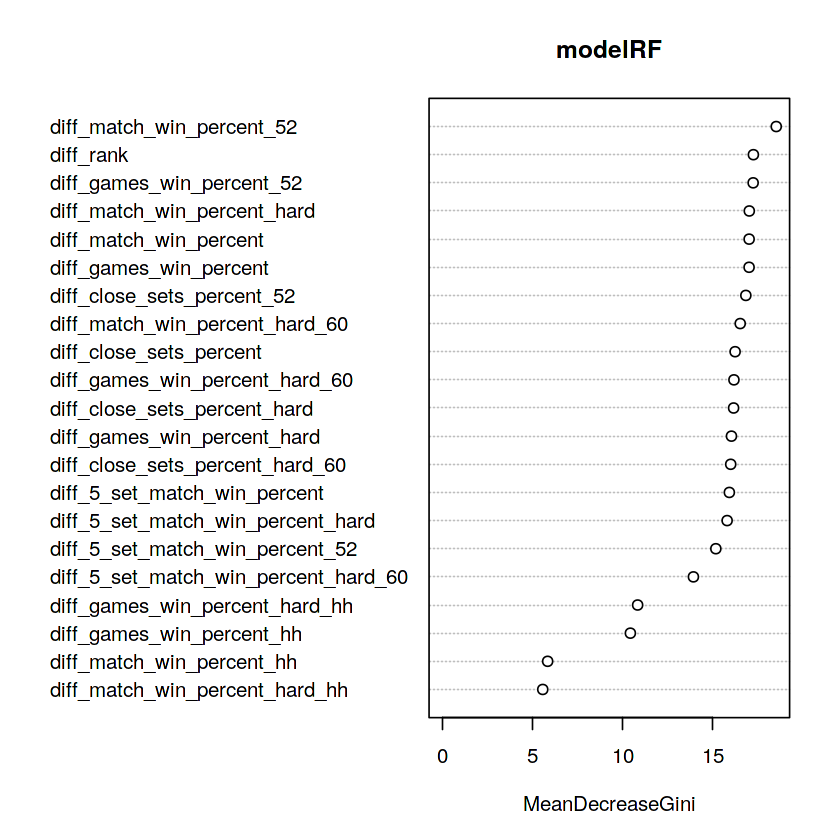

In [29]:
varImpPlot(modelRF)

In [30]:
predRF <- predict(modelRF, newdata=test)

In [31]:
accuracyRF <- sum(diag(table(test$outcome, predRF)))/sum(table(test$outcome, predRF))
accuracyRF

[1] 0.740113

## 7) Accuracy Comparisson:

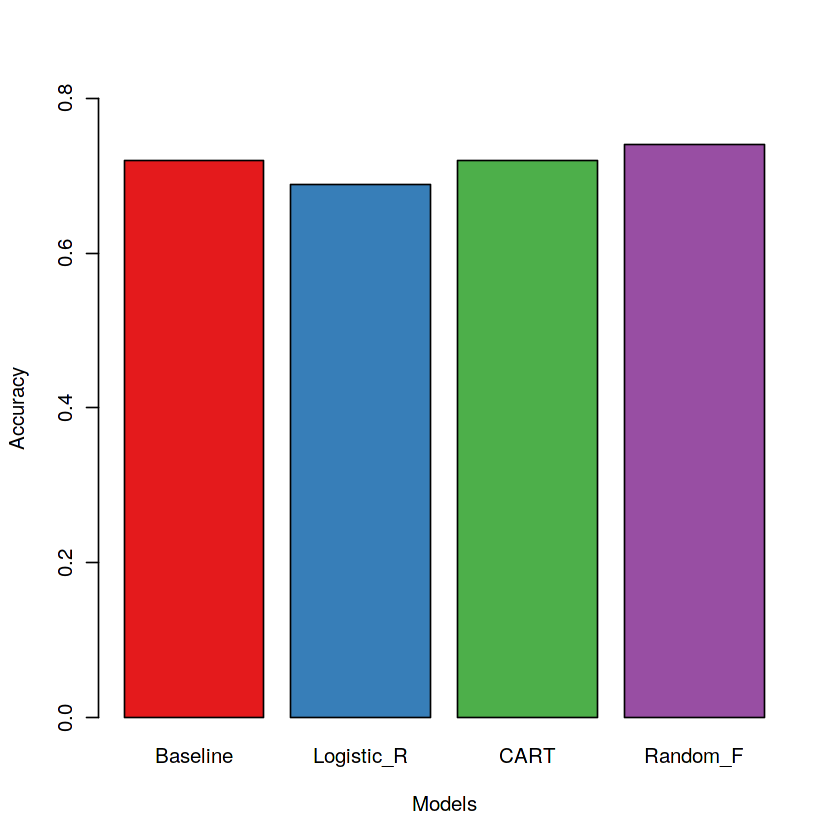

In [32]:
Accuracies <- list("Baseline" = accuracyBaseline, "Logistic_R" = accuracyGLM, "CART" = accuracyCART, "Random_F" = accuracyRF)
barplot(height=unlist(Accuracies),
        col=brewer.pal(4, "Set1"),
        xlab="Models",
        ylab="Accuracy",
        ylim=c(0,0.8))

## Winner: Random Forest! 